## `Process vs Thread`

In [1]:
import time
from concurrent import futures
from tqdm import tqdm
from important_library import io_task, cpu_task

In [2]:
def run_example(n_workers: 'int', n_tasks: 'int', workload: 'str', worker: 'str') -> 'None':
    pool_executor = futures.ThreadPoolExecutor if worker == "thread" else futures.ProcessPoolExecutor
    with pool_executor(n_workers) as executor:
        routine = io_task if workload == "io" else cpu_task
        tasks = [executor.submit(routine, ) for _ in range(n_tasks)]
        for task in tqdm(futures.as_completed(tasks), total=len(tasks)):
            _ = task.result()

In [3]:
for workload in ["cpu", "io"]:
    for n_workers, n_tasks in [(1, 24), (2, 24), (4, 24)]:
        start = time.time()
        run_example(n_workers=n_workers, n_tasks=n_tasks, workload=workload, worker="thread")
        print(f"[# threads = {n_workers}, # tasks = {n_tasks}, workload = {workload}]")
        print(f"Total time {time.time() - start:0.4f} s")
        print("-" * 60)

100%|██████████| 24/24 [00:00<00:00, 98.08it/s] 


[# threads = 1, # tasks = 24, workload = cpu]
Total time 0.6298 s
------------------------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 68.80it/s] 


[# threads = 2, # tasks = 24, workload = cpu]
Total time 0.6751 s
------------------------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 667.46it/s]


[# threads = 4, # tasks = 24, workload = cpu]
Total time 0.6779 s
------------------------------------------------------------


100%|██████████| 24/24 [01:11<00:00,  2.99s/it]


[# threads = 1, # tasks = 24, workload = io]
Total time 71.8136 s
------------------------------------------------------------


100%|██████████| 24/24 [00:46<00:00,  1.94s/it]


[# threads = 2, # tasks = 24, workload = io]
Total time 46.4839 s
------------------------------------------------------------


100%|██████████| 24/24 [00:44<00:00,  1.86s/it]

[# threads = 4, # tasks = 24, workload = io]
Total time 44.7322 s
------------------------------------------------------------


In [4]:
for workload in ["cpu", "io"]:
    for n_workers, n_tasks in [(1, 24), (2, 24), (4, 24)]:
        start = time.time()
        run_example(n_workers=n_workers, n_tasks=n_tasks, workload=workload, worker="process")
        print(f"[# processes = {n_workers}, workload = {workload}]")
        print(f"Total time {time.time() - start:0.4f} s")
        print("-" * 60)

  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 24/24 [00:00<00:00, 34.44it/s]

[# processes = 1, workload = cpu]
Total time 0.7136 s
------------------------------------------------------------



100%|██████████| 24/24 [00:00<00:00, 65.22it/s]

[# processes = 2, workload = cpu]
Total time 0.3833 s
------------------------------------------------------------



100%|██████████| 24/24 [00:00<00:00, 103.05it/s]

[# processes = 4, workload = cpu]
Total time 0.2599 s
------------------------------------------------------------



100%|██████████| 24/24 [01:11<00:00,  2.98s/it]

[# processes = 1, workload = io]
Total time 71.4866 s
------------------------------------------------------------



100%|██████████| 24/24 [00:49<00:00,  2.06s/it]

[# processes = 2, workload = io]
Total time 49.4381 s
------------------------------------------------------------



100%|██████████| 24/24 [00:31<00:00,  1.33s/it]

[# processes = 4, workload = io]
Total time 31.9222 s
------------------------------------------------------------


It's more faster and scalable to use processes in every way. What's the catch?

**Let's take a look at resource consumption ...**
```bash
! ps -x | grep 'Python.app' | wc
```

In [145]:
import psutil
def print_mem():
    total_memory = 0
    for proc in psutil.process_iter(['pid', 'name', 'memory_info']):
        if 'Python' in proc.info['name']:
            total_memory += proc.info['memory_info'].rss
    print(f"Total Python's memory: {total_memory / 1024 / 1024} MB")

In [146]:
def run_example_with_mem_info(n_workers: 'int', n_tasks: 'int', workload: 'str', worker: 'str') -> 'None':
    pool_executor = futures.ThreadPoolExecutor if worker == "thread" else futures.ProcessPoolExecutor
    with pool_executor(n_workers) as executor:
        routine = io_task if workload == "io" else cpu_task
        tasks = [executor.submit(routine, ) for _ in range(n_tasks)]
        time.sleep(1)
        print_mem()
        for task in tqdm(futures.as_completed(tasks), total=len(tasks)):
            _ = task.result()

In [148]:
print_mem()

Total Python's memory: 58.71875 MB


In [149]:
run_example_with_mem_info(n_workers=10, n_tasks=10, workload="cpu", worker="process")

Total Python's memory: 202.84375 MB


100%|██████████| 10/10 [00:00<00:00, 48099.82it/s]


## `Execution workflow`

In [8]:
def print_slogan():
    print("The real science")

In [9]:
import dis
dis.dis(print_slogan)

  2           0 LOAD_GLOBAL              0 (print)
              2 LOAD_CONST               1 ('The real science')
              4 CALL_FUNCTION            1
              6 POP_TOP
              8 LOAD_CONST               0 (None)
             10 RETURN_VALUE


In [10]:
file = "/Users/zinchse/GitHub/parallel_python/important_library.py"
with open(file, "r") as f:
    txt = f.readlines()
    print(f"{file}:\n")
    for l in txt:
        print(l, end="")

/Users/zinchse/GitHub/parallel_python/important_library.py:

import time


N_ITER: 'int' = 1_000_000


def cpu_task() -> 'int':
    res: 'int' = 0
    for i in range(N_ITER):
        if not i % 2023:
            res += i    
    return res


def io_task() -> 'None':
    for i in range(N_ITER):
        time.sleep(0.00000001)


In [11]:
import py_compile
path_to_compiled_file = py_compile.compile(file)

In [12]:
import marshal
with open(path_to_compiled_file, 'rb') as f:
    f.read(16) 
    code = marshal.load(f)
dis.dis(code)

  1           0 SETUP_ANNOTATIONS
              2 LOAD_CONST               0 (0)
              4 LOAD_CONST               1 (None)
              6 IMPORT_NAME              0 (time)
              8 STORE_NAME               0 (time)

  4          10 LOAD_CONST               2 (1000000)
             12 STORE_NAME               1 (N_ITER)
             14 LOAD_CONST               3 ('int')
             16 LOAD_NAME                2 (__annotations__)
             18 LOAD_CONST               4 ('N_ITER')
             20 STORE_SUBSCR

  7          22 LOAD_CONST               3 ('int')
             24 LOAD_CONST               5 (('return',))
             26 BUILD_CONST_KEY_MAP      1
             28 LOAD_CONST               6 (<code object cpu_task at 0x109a1a450, file "/Users/zinchse/GitHub/parallel_python/important_library.py", line 7>)
             30 LOAD_CONST               7 ('cpu_task')
             32 MAKE_FUNCTION            4 (annotations)
             34 STORE_NAME               3 (c

In [14]:
for instr in dis.Bytecode(io_task):
    print(instr.opname)

LOAD_GLOBAL
LOAD_GLOBAL
CALL_FUNCTION
GET_ITER
FOR_ITER
STORE_FAST
LOAD_GLOBAL
LOAD_METHOD
LOAD_CONST
CALL_METHOD
POP_TOP
JUMP_ABSOLUTE
LOAD_CONST
RETURN_VALUE


## `Cython & Threads & GIL & cpu bound task`

In [15]:
import numpy as np

In [16]:
def integrate_square(
        l: 'float', 
        r: 'float', 
        n_steps: 'int'
        ):
    s = 0
    h = (r - l) / n_steps
    for i in range(n_steps):
        x = l + i * h
        f = x ** 2
        s += f * h 
    return s

In [17]:
assert np.isclose(integrate_square(0, 5, 1000000), 5 ** 3 / 3), "Need to increase `steps`!"
print("It works!")

It works!


In [18]:
%%time
integrate_square(0, 5, 1_000_000)

CPU times: user 121 ms, sys: 2.2 ms, total: 124 ms
Wall time: 123 ms


41.66660416668747

In [19]:
def master_py(l: 'int', r: 'int', n_jobs: 'int', n_steps: 'int'):    
    subranges, subrange_length = [], (r - l) / n_jobs

    cur_l = 0
    for i in range(n_jobs):
        cur_l = cur_l + i * subrange_length
        cur_r = cur_l + subrange_length
        subranges.append((cur_l, cur_r))
    
    results = 0
    with futures.ThreadPoolExecutor(n_jobs) as executor:
        tasks = [executor.submit(integrate_square, l, r, n_steps//n_jobs) for l, r in subranges]
        for task in futures.as_completed(tasks):
            results += task.result()
    
    return results

In [20]:
%%timeit -n10
integrate_square(l=0, r=5, n_steps=1_000_000)

110 ms ± 1.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
%%timeit -n10
master_py(l=0, r=5, n_jobs=1, n_steps=1_000_000)

92.1 ms ± 895 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
%%timeit -n10
master_py(l=0, r=5, n_jobs=2, n_steps=1_000_000)

92.4 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
%%timeit -n10
master_py(l=0, r=5, n_jobs=4, n_steps=1_000_000)

93.1 ms ± 1.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


integrate_square.cyx
```python
def integrate_square(int l, int r, int n_steps):
    cdef int i
    cdef double s = 0
    cdef double h = (r - l) / n_steps
    cdef double x, f
    for i in range(n_steps):
        x = l + i * h
        f = x ** 2
        s += f * h 
    return s
```

In [24]:
!cythonize -i integrate_square_c
import pyximport
pyximport.install()
import integrate_square_c

In [25]:
integrate_square_c.integrate_square(0, 5, 10000000)

41.66666010107487

In [26]:
def master_c(l: 'float', r: 'float', n_jobs: 'int', n_steps: 'int'):    
    subranges, subrange_length = [], (r - l) / n_jobs

    cur_l = 0
    for i in range(n_jobs):
        cur_l = cur_l + i * subrange_length
        cur_r = cur_l + subrange_length
        subranges.append((cur_l, cur_r))
    
    results = 0
    with futures.ThreadPoolExecutor(n_jobs) as executor:
        tasks = [executor.submit(integrate_square_c.integrate_square, l, r, n_steps//n_jobs) for l, r in subranges]
        for task in futures.as_completed(tasks):
            results += task.result()
    
    return results

In [27]:
%%timeit -n10
master_c(l=0, r=5, n_jobs=1, n_steps=10_000_000)

10.1 ms ± 738 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
%%timeit -n10
master_c(l=0, r=5, n_jobs=10, n_steps=10_000_000)

3.57 ms ± 1.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
%%timeit -n10
master_py(l=0, r=5, n_jobs=10, n_steps=1_000_000)

93.6 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
%%timeit -n10
master_py(l=0, r=5, n_jobs=1, n_steps=1_000_000)

92.8 ms ± 1.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [31]:
import matplotlib.pyplot as plt
import numpy as np
from timeit import repeat


def plot_dependency(l: 'float', r: 'float', n_jobs_to_try: 'List[int]', n_steps: 'int', save: 'bool' = False):
    py_times = []
    c_times = []
    
    for n_jobs in n_jobs_to_try:
        py_times.append(
            1000 * np.mean(repeat(lambda: master_py(l, r, n_jobs, n_steps), number=1, repeat=10))
        )
        c_times.append(
            1000 * np.mean(repeat(lambda: master_c(l, r, n_jobs, 100 * n_steps), number=1, repeat=10))
        )
    
    plt.style.use("dark_background")
    _, ax = plt.subplots(1, 1, figsize=(16, 8))
    plt.title(f"Cython threads (\wo GIL) vs Python threads (\w GIL) on CPU bound task")
    for times, color, label in ((py_times, "cyan", "Python"), (c_times, "orange", "Cython")):
        ax.plot(
            n_jobs_to_try, times, marker='o', color=color,
            label=label, alpha=0.8, linewidth=7, markersize=20
        )
    ax.set_xlabel('# Threads')
    ax.set_ylabel('Time (ms)')
    ax.grid(True)
    ax.legend()
    ax.set_xlim([0.5, n_jobs_to_try[-1] + 0.5])
    ax.set_ylim([0.0, max(c_times + py_times) * 1.15])
    if save:
        ax.spines['top'].set_color('gray')
        ax.spines['bottom'].set_color('gray')
        ax.spines['left'].set_color('gray')
        ax.spines['right'].set_color('gray')
        ax.title.set_color('gray')
        ax.xaxis.label.set_color('gray')
        ax.yaxis.label.set_color('gray')
        ax.grid(True, color='gray', linestyle='--', linewidth=0.5)
        plt.savefig('cython_vs_python.png', transparent=True)
    plt.show()
    

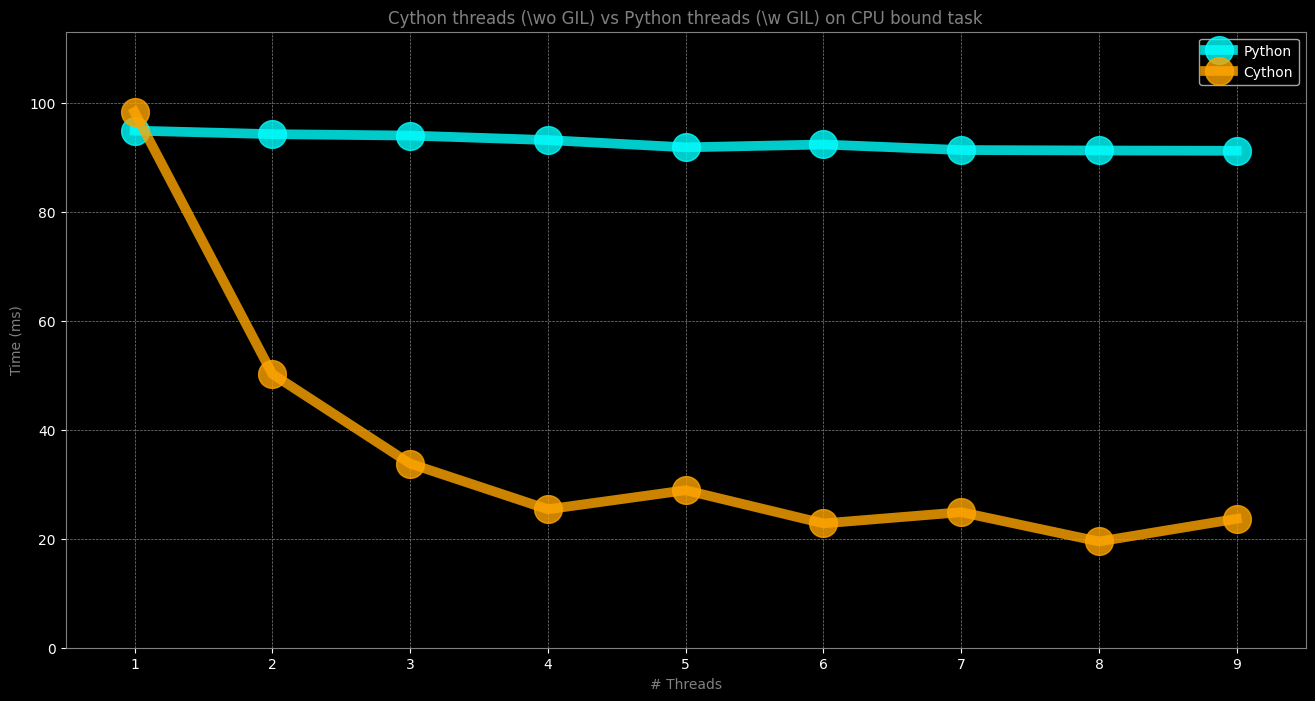

In [32]:
plot_dependency(0, 1, range(1, 10), 1_000_000, save=True)

## `Python & GIL & parallelism`

In [40]:
import threading

In [41]:
def increment(v):
    for _ in range(v):
        global x
        x += 1

In [62]:
x = 0
t1 = threading.Thread(target=increment, args=(100000, ))
t2 = threading.Thread(target=increment, args=(100000, ))
t1.start()
t2.start()
t1.join()
t2.join()
assert x == 100000 + 100000, f"Oops :( x={x}"
print("We are lucky")

We are lucky


## `Thief Thread`

In [36]:
class Money():
    def __init__(self):
        self.money: 'int' = 0
        self._lock: 'threading.Lock' = threading.Lock()

    def get(self, v: 'int') -> 'bool':
        with self._lock:
            if self.money >= v:
                self.money -= v
                print(f"/* getting {v}$ */")
                return True
            else:
                print(f"Sorry, not enough money ({v} vs {self.money})")
                return False
                
    def put(self, v: 'int') -> 'None':
        with self._lock:
            print(f"/* putting {v}$ */")
            self.money += v
                
    def lock(self) -> 'None':
        self._lock.acquire()
        
    def unlock(self) -> 'None':
        self._lock.release()
        
    def get_state(self) -> 'None':
        print(
            {
                "lock is closed": self._lock.locked(),
                "amount of money ($)": self.money
            }
        )

In [37]:
my_money = Money()
my_money.put(1000)
my_money.lock()
my_money.get_state()

/* putting 1000$ */
{'lock is closed': True, 'amount of money ($)': 1000}


In [38]:
def thief_thread():
    print("[thief]: I am here.")
    my_money.get_state()
    if my_money._lock.locked():
        print("[thief]: Hm. It seems that money is locked. Lets unlock it ...")
        my_money.unlock()        
    if my_money.get(1000 - 7):
        print("[thief]: Easy")
    else:
        print("[thied]: Very little money. I will leave it to the poor.")
    my_money.get_state()

In [39]:
#print("[main thread]: money is locked")
t = threading.Thread(target=thief_thread)
t.start()
t.join()


[thief]: I am here.
{'lock is closed': True, 'amount of money ($)': 1000}
[thief]: Hm. It seems that money is locked. Lets unlock it ...
/* getting 993$ */
[thief]: Easy
{'lock is closed': False, 'amount of money ($)': 7}


## `Unbouded Semaphore`

In [58]:
semaphore = threading.Semaphore(1)

In [59]:
def worker(thread_id):
    with semaphore:
        print(f"Thread {thread_id} has acquired the semaphore and is working", flush=True)
        time.sleep(0.1)
        print(f"Thread {thread_id} is doing some work ...", flush=True)
        time.sleep(2)
        print(f"Thread {thread_id} has released the semaphore", flush=True)
        time.sleep(0.1)

In [60]:
def do_work():
    threads = []
    for i in range(3):
        thread = threading.Thread(target=worker, args=(i, ))
        threads.append(thread)
        thread.start()
        
    for thread in threads:
        thread.join()
    print("All threads have finished")


In [61]:
do_work()

Thread 0 has acquired the semaphore and is working
Thread 0 is doing some work ...
Thread 0 has released the semaphore
Thread 1 has acquired the semaphore and is working
Thread 1 is doing some work ...
Thread 1 has released the semaphore
Thread 2 has acquired the semaphore and is working
Thread 2 is doing some work ...
Thread 2 has released the semaphore
All threads have finished
